Get the data

In [12]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np

In [34]:
driver = 'mysql+pymysql:'
user = 'root'
password = '17028854'
ip = '35.195.111.11'
database = 'Avocalypse'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [3]:
gtrend = pd.read_sql('gtrend',con=engine)

In [4]:
gtrend['year'] = gtrend['year'].astype('int64')
gtrend['month'] = gtrend['month'].astype('int64')
gtrend['popularity'] = gtrend['popularity'].astype('int64')

In [6]:
gtrend_2006_2016 = gtrend[gtrend['year']>2005]
gtrend_2006_2016 = gtrend_2006_2016[gtrend_2006_2016['year']<2017]

We will plot a linear model and check the fit

In [10]:
gtrend_2006_2016.head(1)

,index,year,month,popularity
24,24,2006,1,18


In [17]:
sb.set(rc={'figure.figsize':(15,8)})

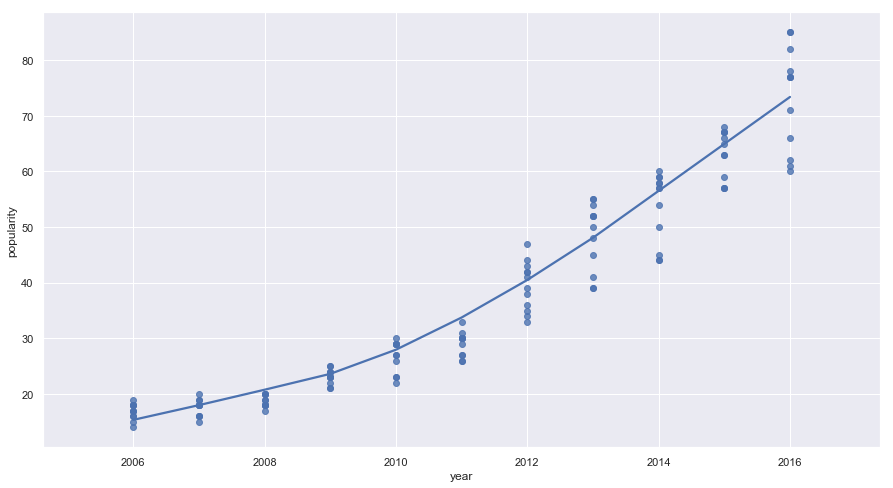

In [18]:
sns.regplot(x="year", y="popularity", data=gtrend_2006_2016,lowess=True);

In [25]:
gtrend_2006_2016 = gtrend_2006_2016.reset_index(drop=True).drop(columns='index').reset_index().rename(columns={'index':'time'})

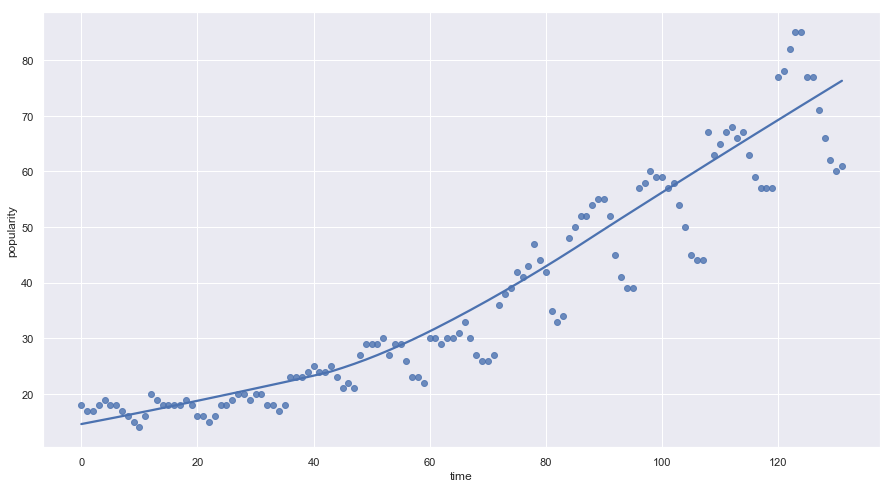

In [27]:
sns.regplot(x="time", y="popularity", data=gtrend_2006_2016,lowess=True);

In [31]:
gtrend_2006_2016_yearly = gtrend_2006_2016.groupby('year').mean().reset_index()

In [136]:
gtrend_2006_2016_yearly

,year,time,month,popularity
0,2006,5.5,6.5,16.916667
1,2007,17.5,6.5,17.583333
2,2008,29.5,6.5,18.750000
3,2009,41.5,6.5,23.166667
4,2010,53.5,6.5,26.916667
5,2011,65.5,6.5,29.083333
6,2012,77.5,6.5,39.500000
7,2013,89.5,6.5,48.500000
8,2014,101.5,6.5,53.750000
9,2015,113.5,6.5,63.000000


In [144]:
gtrend_2006_2016_yearly['regression']=2097337-2091.582*gtrend_2006_2016_yearly['year']+0.5214647*gtrend_2006_2016_yearly['year']**2
#gtrend_2006_2016_yearly['regression_b']=-2091.582*gtrend_2006_2016_yearly['year']
#gtrend_2006_2016_yearly['regression_c']=0.5214647*gtrend_2006_2016_yearly['year']**2
gtrend_2006_2016_yearly = gtrend_2006_2016_yearly.drop(columns=['regression_a','regression_b','regression_c'])

In [173]:
gtrend_2006_2016_yearly

,year,time,month,popularity,regression
0,2006,5.5,6.5,16.916667,16.233529
1,2007,17.5,6.5,17.583333,17.289370
2,2008,29.5,6.5,18.750000,19.388141
3,2009,41.5,6.5,23.166667,22.529841
4,2010,53.5,6.5,26.916667,26.714470
5,2011,65.5,6.5,29.083333,31.942029
6,2012,77.5,6.5,39.500000,38.212517
7,2013,89.5,6.5,48.500000,45.525934
8,2014,101.5,6.5,53.750000,53.882281
9,2015,113.5,6.5,63.000000,63.281558


In [176]:
gtrend_2006_2016_yearly.to_csv('popularity_model.csv')
gtrend_2006_2016_yearly.to_excel('popularity_model.xls')

In [ ]:
#Add here year vs popularity, incl. regression

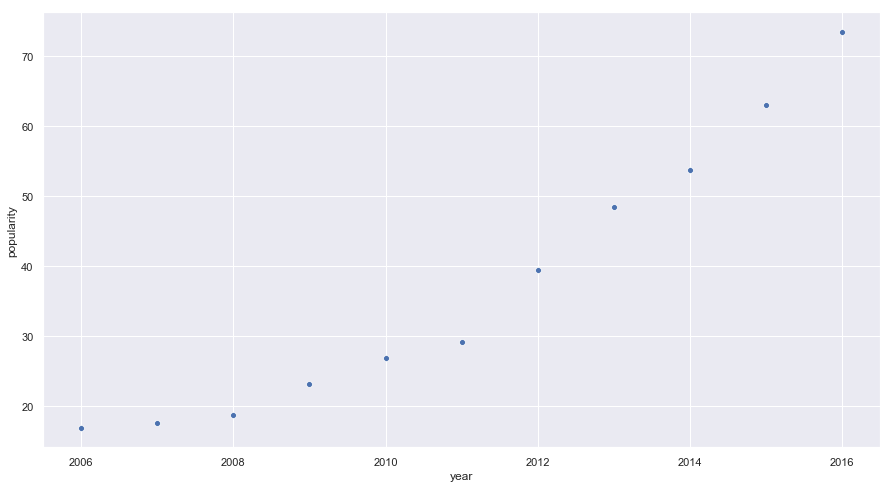

In [145]:
sns.scatterplot(data=gtrend_2006_2016_yearly,x='year',y='popularity')

Get data for pricing

In [37]:
prices = pd.read_sql('prices',con=engine)
countries = pd.read_sql('countries',con=engine)

In [38]:
countries = countries.drop(columns='index')
prices = prices.drop(columns='index')
prices_country = prices.merge(countries, how='left', on='Area Code')

In [45]:
top10_2016 = ['Mexico', 'Dominican Republic', 'Peru', 'Indonesia', 'Colombia', 'Brazil', 'Kenya', 'Chile', 'Venezuela (Bolivarian Republic of)', 'United States of America', 'China']

In [112]:
prices_country.head()

,Area Code,Year Code,Value,Area
0,9,2007,123.086061,Argentina
1,9,2008,155.952012,Argentina
2,9,2009,139.891744,Argentina
3,9,2010,171.921928,Argentina
4,9,2011,215.123273,Argentina


In [114]:
top10_prices = prices_country[prices_country['Area'].isin(top10_2016)]

In [116]:
inflation = pd.read_sql('inflation',con=engine)

In [117]:
inflation = inflation.rename(columns={'Value':'inflation'}).drop(columns='index')

In [118]:
top10_prices = top10_prices.merge(inflation,how='left',left_on=['Year Code','Area'],right_on=['Year','country'])

We drop Venezuela due to missing data on inflation

In [124]:
top10_prices = top10_prices[:104]

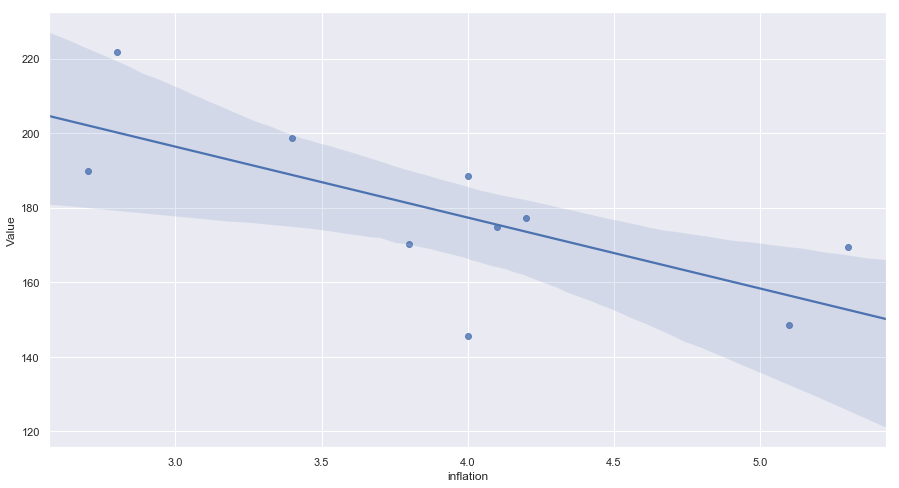

In [125]:
sns.regplot(data=top10_prices[top10_prices['country']=='Mexico'],x='inflation',y='Value')

There is no relation between inflation and the price of avocado. Mexico is shown as an example only

In [126]:
top10_prices_yearly = top10_prices.groupby('Year Code').mean().reset_index()[['Year Code','Value','inflation']]

In [127]:
top10_prices_yearly.head()

,Year Code,Value,inflation
0,2007,122.928843,4.800000
1,2008,149.552836,8.711111
2,2009,155.572161,3.355556
3,2010,171.981252,3.144444
4,2011,191.596539,5.366667


In [128]:
summary_data = top10_prices_yearly.merge(gtrend_2006_2016_yearly,how='inner',left_on='Year Code',right_on = 'year')

In [164]:
#Regression found, with R**2 = 0.8918, aR**2=0.8455, P=0.0009273, F=19.24
Y0=-265.8751
V0=-50.14305
k=0.1074086

In [167]:
summary_data['regression_value']=Y0-(V0/k)*(1-np.exp(-k*summary_data['popularity']))

In [177]:
summary_data.to_csv('correlation_model.csv')
summary_data.to_excel('correlation_model.xls')

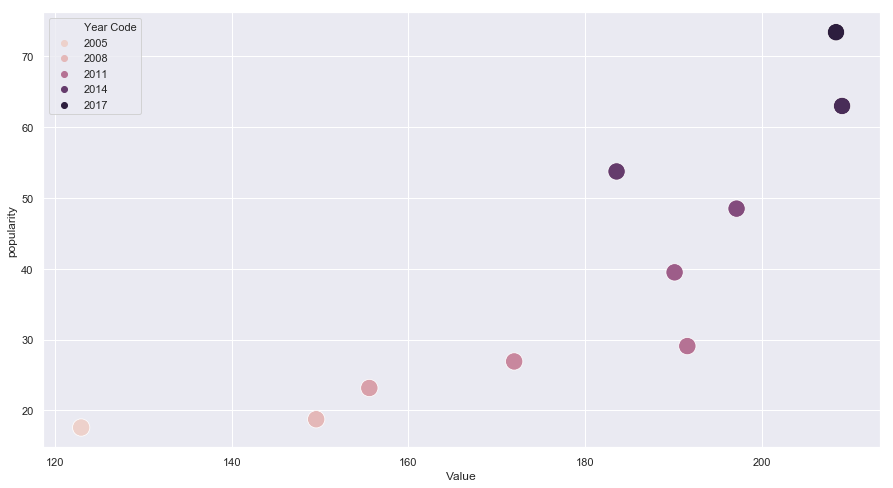

In [135]:
sns.scatterplot(data=summary_data,x='Value',y='popularity',hue='Year Code',s=300)